----- nuria ----
Observed day averages (all, th2, tot): (25.14, 22.69, 2.45)
Total rate surplus: 	11.58%
Th2 rate surplus: 	10.68%
ToT(d) rate surplus: 	25.78%


----- lo_qui_don ----
Observed day averages (all, th2, tot): (23.19, 22.43, 0.76)
Total rate surplus: 	10.67%
Th2 rate surplus: 	10.23%
ToT(d) rate surplus: 	23.11%




Text(0.52, 0.01, '$\\Delta$I$_\\mathrm{VEM}$ / I$_\\mathrm{VEM}$ / \\%')

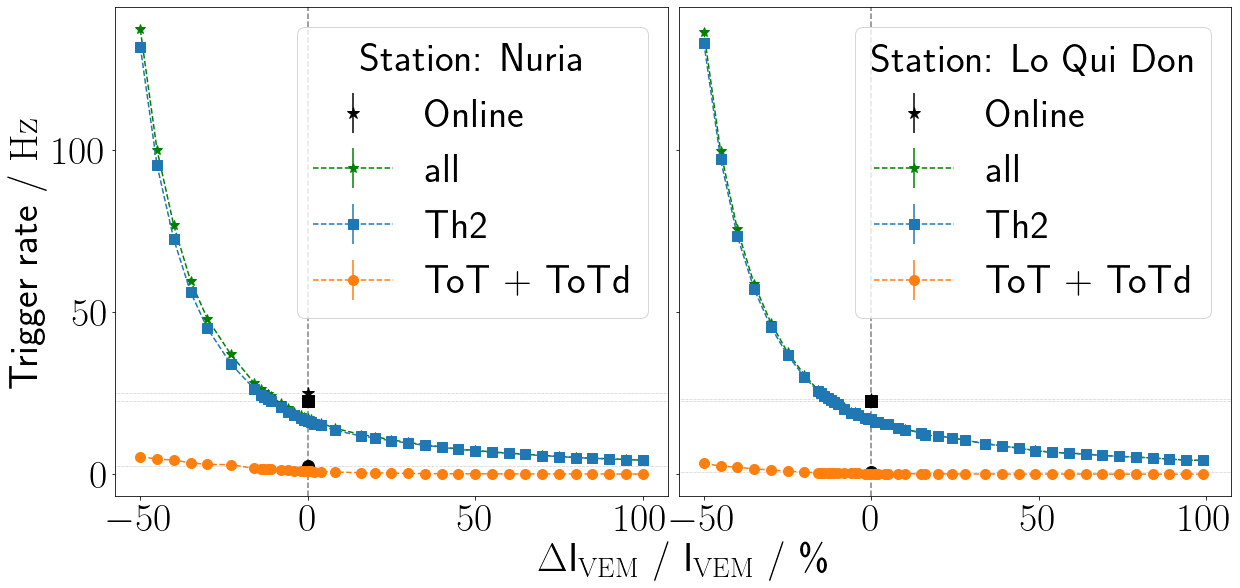

In [8]:
from Binaries import *
import uproot

def neg_exponential(x, a, b):
    return a * np.exp(- b * x)

stations = \
    {
        "nuria" : 56,
        "lo_qui_don" : 1744,
    }

plt.rcParams["figure.figsize"] = [20, 9]
fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey = True)

axes = \
    {
        "nuria" : ax1,
        "lo_qui_don" : ax2
    }

for directory in os.listdir("./trigger_output"):

    ax = axes[directory]

    r_th2, r_tot = [], []
    e_th2, e_tot = [], []
    x, r_total = [], []
    e_total = []
    x_online = []


    file = uproot.open("/cr/tempdata01/filip/iRODS/MonitoringData/mc_2022_03_17_00h00.root:SDMonCal")
    StationIDs = file['SDMonCalBranch']['fLsId'].array()
    data = file['fCalibration']

    Station = StationIDs == stations[directory]

    starts = data['fCalibration.fStartSecond'].array()[Station]
    deltas = data['fCalibration.fEndSecond'].array()[Station]

    for j, trigger in enumerate(['fCalibration.fT2', 'fCalibration.fTotRate', 'fCalibration.fTotD']): # , 'fCalibration.fMops']):

        if j != 1: x_online.append(data[trigger].array()[Station] / deltas)
        else: x_online.append(data[trigger].array()[Station])

    Th2 = x_online[0]
    ToTd = x_online[1]+ x_online[2]
    Total = Th2 + ToTd

    Th2, Th2_err = np.mean(Th2), np.std(Th2)
    ToTd, ToTd_err = np.mean(ToTd), np.std(ToTd)
    Total, Total_err = np.mean(Total), np.std(Total)
    x = []

    for file in os.listdir(f"./trigger_output/{directory}/"):

        if os.path.isdir("/cr/users/filip/Trigger/RunProductionTest/trigger_output/" + directory + "/" + file): continue

        t, th2, tot, tod = np.loadtxt("/cr/users/filip/Trigger/RunProductionTest/trigger_output/" + directory + "/" + file, unpack = True, usecols = [2,4,5,6])

        p = file.split("_")[-1][:-4]

        try:
            x.append(float(p[1:]) if p[0] == "p" else -1 * float(p[1:]))
        except ValueError: x.append(0)

        duration = t.sum()
        rate_th2 = th2.sum() / duration
        rate_tot = tot.sum() / duration
        rate_tod = tod.sum() / duration
        error_th2 = np.std(th2)
        error_tot = np.std(tot)
        error_tod = np.std(tod)

        r_th2.append(rate_th2)
        r_tot.append(rate_tot + rate_tod)

        rate_total = rate_th2 + rate_tot + rate_tod
        error_total = np.sqrt(error_th2**2 + error_tot**2 + error_tod**2)
        r_total.append(rate_total)
        
        e_th2.append(error_th2 / duration)
        e_tot.append(np.sqrt(error_tot**2 + error_tod**2) / duration)
        e_total.append(error_total / duration)

    ii = np.argsort(x)
    x = np.array(x)[ii]
    r_total = np.array(r_total)[ii]
    r_th2 = np.array(r_th2)[ii]
    r_tot = np.array(r_tot)[ii]

    X = np.linspace(-23, 16, 100)
    popt_total, pcov = curve_fit(neg_exponential, x, r_total, bounds = (0, np.inf), p0 = [r_total[11], 1])
    # ax.plot(X, neg_exponential(X, *popt_tot))
    popt_th2, pcov = curve_fit(neg_exponential, x, r_th2, bounds = (0, np.inf), p0 = [r_th2[11], 1])
    # ax.plot(X, neg_exponential(X, *popt_th2))
    popt_tot, pcov = curve_fit(neg_exponential, x, r_tot, bounds = (0, np.inf), p0 = [r_tot[11], 1])
    # ax.plot(X, neg_exponential(X, *popt_tot))

    ax.errorbar(0, Total, yerr = Total_err, fmt = "k*", label = "Online", markersize = 12)
    ax.errorbar(0, ToTd, yerr = ToTd_err, fmt = "ko", markersize = 12)
    ax.errorbar(0, Th2, yerr = Th2_err, fmt = "ks", markersize = 12)

    ax.errorbar(x, r_total, yerr = e_total, fmt = "--g*", label ="all", markersize = 10)
    ax.errorbar(x, r_th2, yerr = e_th2, fmt = "--s", label ="Th2", markersize = 10)
    ax.errorbar(x, r_tot, yerr = e_tot, fmt = "--o", label ="ToT + ToTd", markersize = 10)
    ax.axhline(Total, ls = ":", lw = 0.5, c = "gray")
    ax.axhline(ToTd, ls = ":", lw = 0.5, c = "gray")
    ax.axhline(Th2, ls = ":", lw = 0.5, c = "gray")

    ax.legend(title = f"Station: {directory.replace('_', ' ').title()}")
    ax.axvline(0, c = "gray", ls = "--")

    print(f"----- {directory} ----")
    print(f"Observed day averages (all, th2, tot): ({Total:.2f}, {Th2:.2f}, {ToTd:.2f})")
    print(f"Total rate surplus: \t{np.log(Total/popt_total[0])/popt_total[1]:.2f}%")
    print(f"Th2 rate surplus: \t{np.log(Th2/popt_th2[0])/popt_th2[1]:.2f}%")
    print(f"ToT(d) rate surplus: \t{np.log(ToTd/popt_tot[0])/popt_tot[1]:.2f}%")
    print("\n")

plt.subplots_adjust(hspace=0, wspace=0.02)
fig.text(0.05, 0.5, "Trigger rate / $\mathrm{Hz}$", rotation = 90, verticalalignment = "center")
fig.text(0.52, 0.01, r"$\Delta$I$_\mathrm{VEM}$ / I$_\mathrm{VEM}$ / \%", horizontalalignment = "center")
# ax1.set_xlabel(r"$\Delta$I$_\mathrm{VEM}$ / I$_\mathrm{VEM}$ / \%")
# ax1.set_ylabel("Trigger rate / Hz")

In [4]:
print(r_total[np.argmin(np.abs(x))])
print(Total)

17.128158766592975
23.190801451415837


In [5]:
a = 17.128158766592975
b = 23.190801451415837

print(a/b - 1)

-0.26142445734460495
